In [36]:
import cartopy.crs as ccrs
import fsspec
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import planetary_computer
import pystac_client
import xarray as xr

In [37]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [38]:
longitude = 79.109
latitude = 22.746

geometry = {
    "type": "Point",
    "coordinates": [longitude, latitude],
}

search = catalog.search(
    collections="sentinel-5p-l2-netcdf",
    intersects=geometry,
    datetime="2023-03-03/2023-05-03",
    query={"s5p:processing_mode": {"eq": "OFFL"}, "s5p:product_name": {"eq": "hcho"}},
)
items = list(search.items())

print(f"Found {len(items)} items:")
print(items)


Found 66 items:
[<Item id=S5P_L2_HCHO___20230503T071510_20230503T085640_28771>, <Item id=S5P_L2_HCHO___20230502T073405_20230502T091535_28757>, <Item id=S5P_L2_HCHO___20230501T075300_20230501T093430_28743>, <Item id=S5P_L2_HCHO___20230430T063024_20230430T081155_28728>, <Item id=S5P_L2_HCHO___20230429T064919_20230429T083050_28714>, <Item id=S5P_L2_HCHO___20230428T070814_20230428T084944_28700>, <Item id=S5P_L2_HCHO___20230427T072708_20230427T090839_28686>, <Item id=S5P_L2_HCHO___20230426T074603_20230426T092733_28672>, <Item id=S5P_L2_HCHO___20230425T062327_20230425T080457_28657>, <Item id=S5P_L2_HCHO___20230424T064221_20230424T082352_28643>, <Item id=S5P_L2_HCHO___20230423T070115_20230423T084246_28629>, <Item id=S5P_L2_HCHO___20230422T072009_20230422T090140_28615>, <Item id=S5P_L2_HCHO___20230421T073903_20230421T092034_28601>, <Item id=S5P_L2_HCHO___20230420T075757_20230420T093928_28587>, <Item id=S5P_L2_HCHO___20230420T061627_20230420T075757_28586>, <Item id=S5P_L2_HCHO___20230419T063520

In [39]:
f = fsspec.open(items[0].assets["hcho"].href).open()
ds = xr.open_dataset(f, group="PRODUCT", engine="h5netcdf")
ds

<xarray.Dataset>
Dimensions:                                              (scanline: 4173,
                                                          ground_pixel: 450,
                                                          time: 1, corner: 4,
                                                          layer: 34)
Coordinates:
  * scanline                                             (scanline) float64 0...
  * ground_pixel                                         (ground_pixel) float64 ...
  * time                                                 (time) datetime64[ns] ...
  * corner                                               (corner) float64 0.0...
  * layer                                                (layer) int32 0 ... 33
Data variables:
    latitude                                             (time, scanline, ground_pixel) float32 ...
    longitude                                            (time, scanline, ground_pixel) float32 ...
    delta_time                                           (time, scanline, ground_pixel) datetime64[ns] ...
    time_utc                                             (time, scanline) object ...
    qa_value                                             (time, scanline, ground_pixel) float32 ...
    formaldehyde_tropospheric_vertical_column            (time, scanline, ground_pixel) float32 ...
    formaldehyde_tropospheric_vertical_column_precision  (time, scanline, ground_pixel) float32 ...

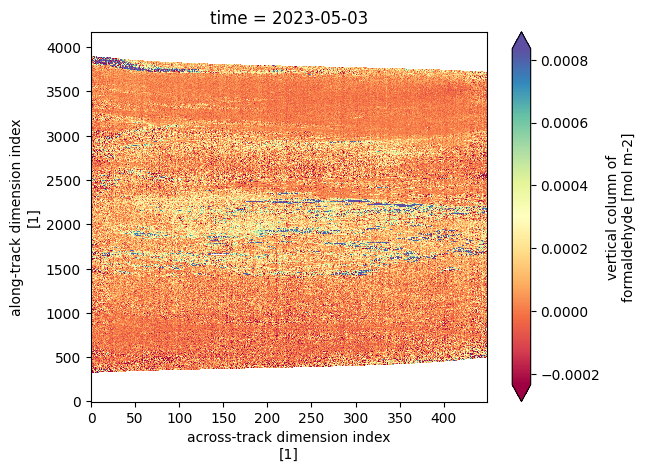

In [40]:
varname = "formaldehyde_tropospheric_vertical_column"
data = ds[varname][0, :, :]
vmin, vmax = np.nanpercentile(data, [1, 99])
data.plot(vmin=vmin, vmax=vmax, cmap="Spectral");

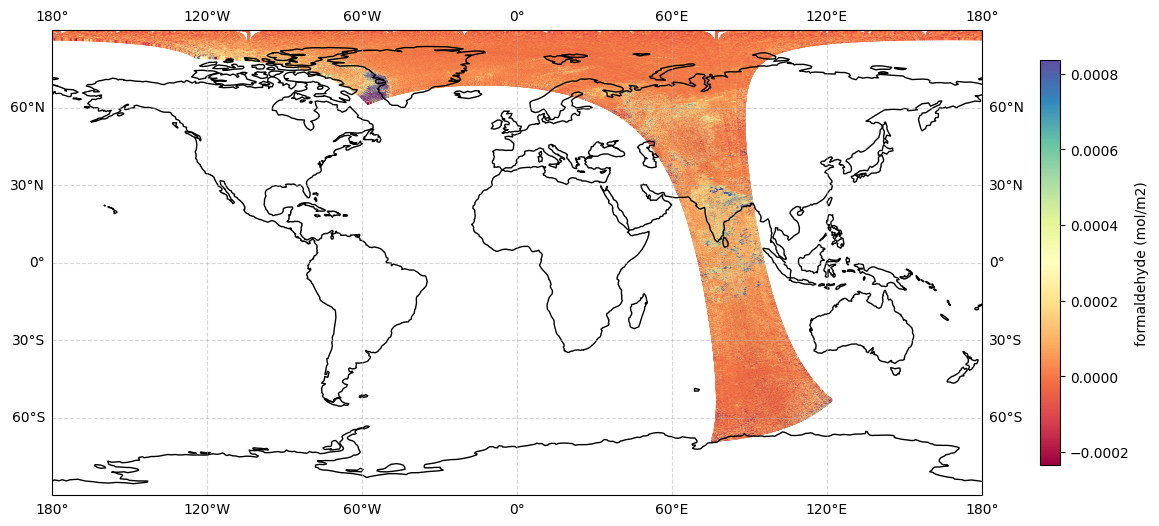

In [41]:
# formaldehyde product (NaN locations are transparent)
lon = ds["longitude"].values.squeeze()
lat = ds["latitude"].values.squeeze()
formaldehyde = data.values

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5, linestyle="--")
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
scatter = plt.scatter(
    lon,
    lat,
    c=formaldehyde,
    transform=ccrs.PlateCarree(),
    cmap="Spectral",
    norm=norm,
    marker="o",
    s=1,
)
fig.colorbar(scatter, pad=0.05, shrink=0.35, label="formaldehyde (mol/m2)")
plt.show()

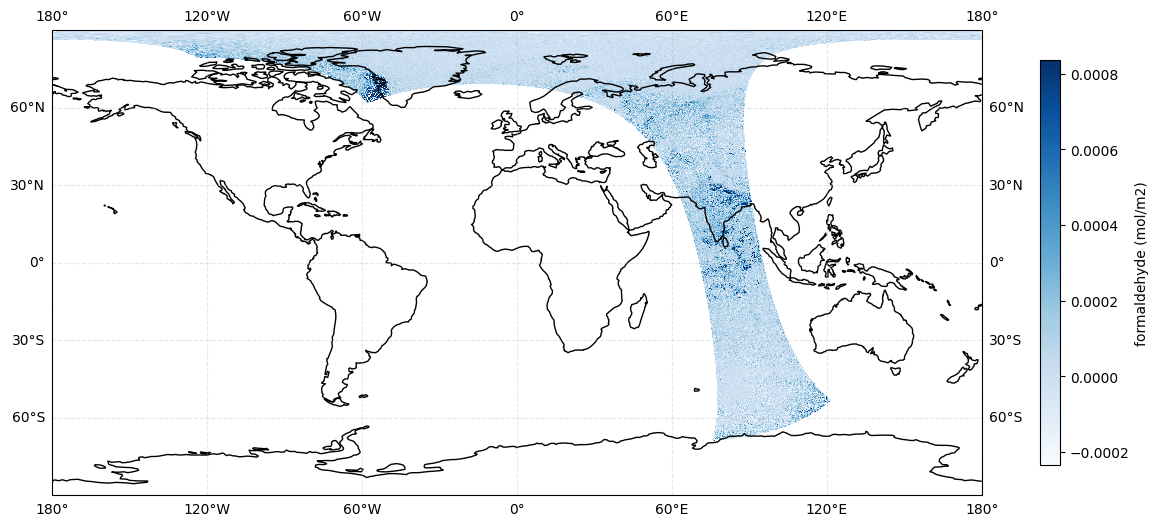

In [43]:
lon = ds["longitude"].values.squeeze()
lat = ds["latitude"].values.squeeze()

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.3, linestyle="--")
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

colormesh = ax.pcolormesh (lon, lat, formaldehyde, cmap = "Blues", norm = norm)
fig.colorbar(colormesh, pad=0.05, shrink=0.35, label="formaldehyde (mol/m2)")
